# Image classification for identification of eye diseases using eye disease retinal image dataset.
##### Auther of this project:
    Md. Saif Ahammod Khan
    ID: 2315333650
    

## 1. Importing The Required Libraries

In [1]:
import os
import random
import shutil
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import load_model
from sklearn.utils import class_weight
from sklearn.metrics import classification_report, confusion_matrix, top_k_accuracy_score
import matplotlib.pyplot as plt
import numpy as np
import pathlib
from PIL import Image
from pathlib import Path
import cv2

## 2. Importing Dataset
Dataset link:

In [2]:
# Please input your local path of the dataset
# E.G "E:\Workplace\Projects\Eye disease detection\dataset"
local_path = 'E:\Workplace\Projects\Eye disease detection\dataset'
data_dir = pathlib.Path(local_path)

## 3. Data Visualization Before Image Processing

### 3.1 Counting Total Image

In [3]:
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

2918


### 3.2 Counting Total Class

In [4]:
# Get a list of subdirectories in data_dir
subdirectories = [item for item in data_dir.iterdir() if item.is_dir()]

# Count the number of subdirectories, which represents the number of classes
num_classes = len(subdirectories)

print("Number of classes:", num_classes)

Number of classes: 4


### 3.3 Counting The The Number of Images In Each Class

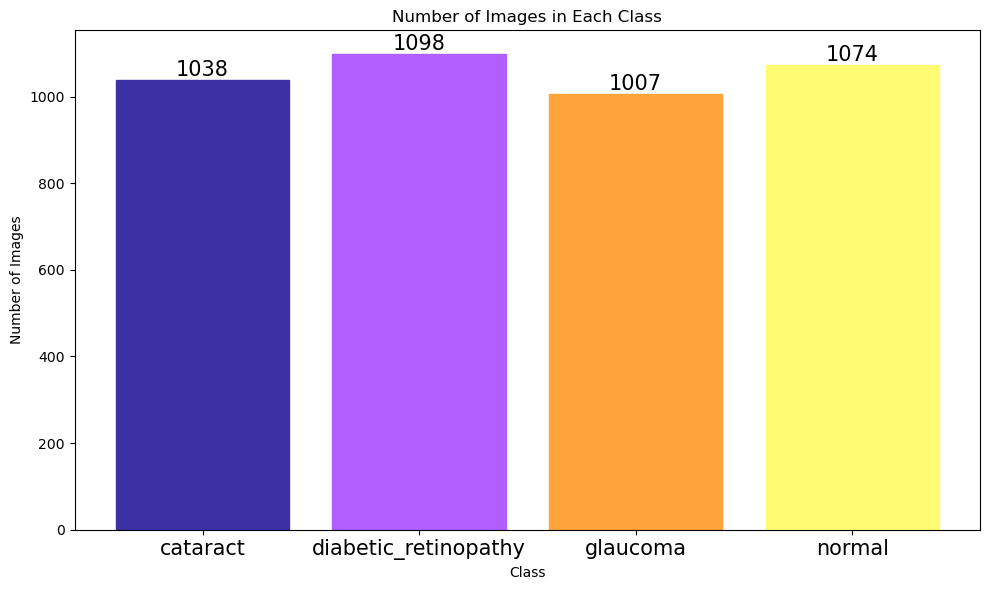

In [5]:
# Initialize a dictionary to store class names and image counts
class_counts = {}
# Iterate through subdirectories (classes) in data_dir
for class_dir in data_dir.iterdir():
    if class_dir.is_dir():
        class_name = class_dir.name
        # Count the number of image files in the class directory
        image_count = len([f for f in class_dir.iterdir() if f.is_file()])
        class_counts[class_name] = image_count
# Extract class names and counts for plotting
class_names = list(class_counts.keys())
image_counts = list(class_counts.values())
# Define a list of colors for the bars (you can customize the colors)
colors = [plt.cm.viridis(random.random()) for _ in class_names]
# Create a bar chart with custom colors
plt.figure(figsize=(10, 6))
bars = plt.bar(class_names, image_counts, color=colors)
plt.xlabel('Class')
plt.ylabel('Number of Images')
plt.title('Number of Images in Each Class')
plt.xticks(rotation=0, fontsize=15, ha="center")
# Customize the colors of the bars
# Define a list of custom colors for the bars
custom_colors = ['#3D30A2', '#B15EFF', '#FFA33C', '#FFFB73']
c=0
for bar, color in zip(bars, colors):
    bar.set_color(custom_colors[c])
    c=c+1

# Add count labels on top of the bars
for bar, count in zip(bars, image_counts):
    plt.text(bar.get_x() + bar.get_width() / 2, count, str(count),fontsize=15, ha='center', va='bottom')
plt.tight_layout()
# Show the bar chart
plt.show()

### 3.4 Data Sample Visualization of Each Class

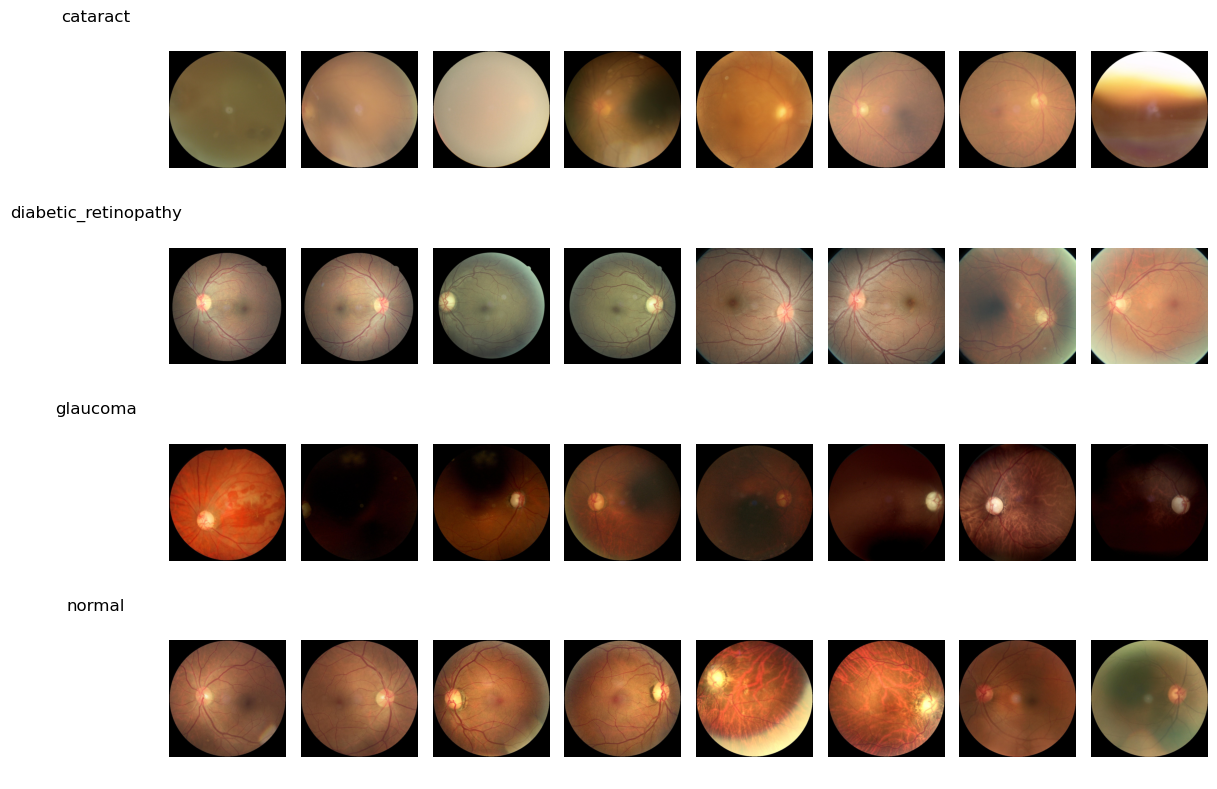

In [6]:

# Show 8 images from each class
num_images_to_display = 8  # Display 8 images for each class

num_rows = len(class_names)
num_cols = num_images_to_display + 1  # +1 for the title

plt.figure(figsize=(12, 8))

for i, class_name in enumerate(class_names):
    class_dir = data_dir / class_name
    image_files = list(class_dir.glob('*.*'))
    if image_files:
        plt.subplot(num_rows, num_cols, i * num_cols + 1)
        plt.title(class_name)
        plt.axis('off')
        for j in range(num_images_to_display):
            if j < len(image_files):
                sample_image = Image.open(image_files[j])
                plt.subplot(num_rows, num_cols, i * num_cols + j + 2)
                plt.imshow(sample_image)
                plt.axis('off')

plt.tight_layout()
plt.show()

## 4. Image Processing

### 4.1 Histogram Equalization

#### 4.1.1 Applying Histogram Equalization

In [44]:
output_dir = 'E:\Workplace\Projects\Eye disease detection\equalized_dataset'

# Ensure the output directory exists or create it
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Define a function to apply histogram equalization to a color image
def equalize_color_image(image):
    # Convert the image to LAB color space
    lab = cv2.cvtColor(image, cv2.COLOR_BGR2LAB)
    
    # Split the LAB image into L, A, and B channels
    l, a, b = cv2.split(lab)
    
    # Apply histogram equalization to the L channel
    l_equalized = cv2.equalizeHist(l)
    
    # Merge the equalized L channel with the original A and B channels
    equalized_lab = cv2.merge((l_equalized, a, b))
    
    # Convert the LAB image back to BGR color space
    equalized_bgr = cv2.cvtColor(equalized_lab, cv2.COLOR_LAB2BGR)
    
    return equalized_bgr

# Loop through the original dataset and copy, then equalize the color images
for class_dir in data_dir.iterdir():
    if class_dir.is_dir():
        output_class_dir = os.path.join(output_dir, class_dir.name)
        os.makedirs(output_class_dir, exist_ok=True)
        
        for image_path in class_dir.iterdir():
            if image_path.is_file():
                image = cv2.imread(str(image_path))
                
                if image is not None:
                    equalized_img = equalize_color_image(image)
                    output_path = os.path.join(output_class_dir, image_path.name)
                    cv2.imwrite(output_path, equalized_img)

print("Histogram equalization for color (RGB) images completed and saved in the output directory.")

Histogram equalization for color (RGB) images completed and saved in the output directory.


#### 4.1.2 Data Sample Visualization of Each Class

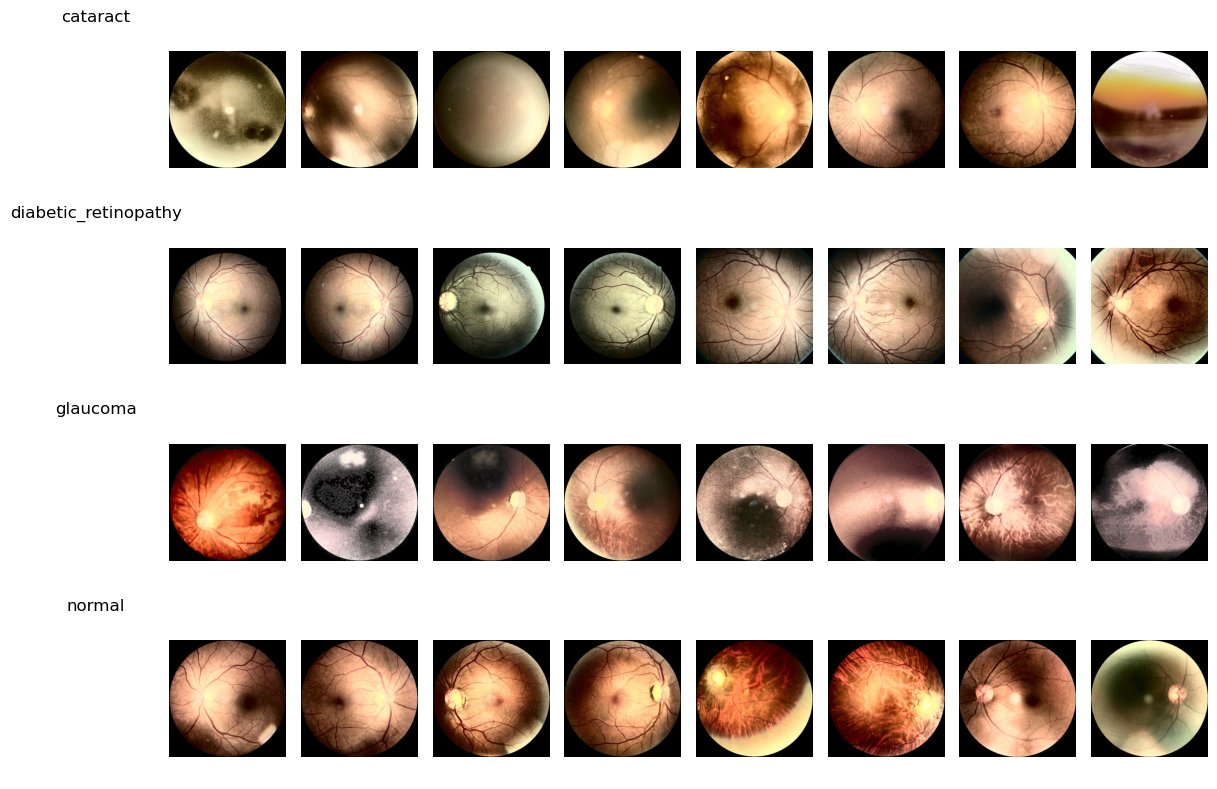

In [7]:
local_path = 'E:\Workplace\Projects\Eye disease detection\equalized_dataset'
data_dir = pathlib.Path(local_path)
# Show 8 images from each class
num_images_to_display = 8  # Display 8 images for each class

num_rows = len(class_names)
num_cols = num_images_to_display + 1  # +1 for the title

plt.figure(figsize=(12, 8))

for i, class_name in enumerate(class_names):
    class_dir = data_dir / class_name
    image_files = list(class_dir.glob('*.*'))
    if image_files:
        plt.subplot(num_rows, num_cols, i * num_cols + 1)
        plt.title(class_name)
        plt.axis('off')
        for j in range(num_images_to_display):
            if j < len(image_files):
                sample_image = Image.open(image_files[j])
                plt.subplot(num_rows, num_cols, i * num_cols + j + 2)
                plt.imshow(sample_image)
                plt.axis('off')

plt.tight_layout()
plt.show()

### 4.2 Noise Cancellition 

#### 4.2.1 Applying Noise Cancellition

In [50]:

# Define the source and destination paths
local_path = 'E:\Workplace\Projects\Eye disease detection\equalized_dataset'
data_dir = pathlib.Path(local_path)
output_dir = 'E:\Workplace\Projects\Eye disease detection\noise_reduced_dataset'

# Ensure the output directory exists or create it
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Define a function to apply noise reduction to an image
def denoise_image(image):
    # Apply non-local means denoising
    denoised_img = cv2.fastNlMeansDenoisingColored(image, None, 10, 10, 7, 21)
    
    return denoised_img

# Loop through the equalized dataset and apply noise reduction
for class_dir in data_dir.iterdir():
    if class_dir.is_dir():
        output_class_dir = os.path.join(output_dir, class_dir.name)
        os.makedirs(output_class_dir, exist_ok=True)
        
        for image_path in class_dir.iterdir():
            if image_path.is_file():
                image = cv2.imread(str(image_path))
                
                if image is not None:
                    denoised_img = denoise_image(image)
                    output_path = os.path.join(output_class_dir, image_path.name)
                    cv2.imwrite(output_path, denoised_img)

print("Noise reduction applied to the equalized dataset and saved in the output directory.")

Noise reduction applied to the equalized dataset and saved in the output directory.


#### 4.2.2 Data Sample Visualization of Each Class

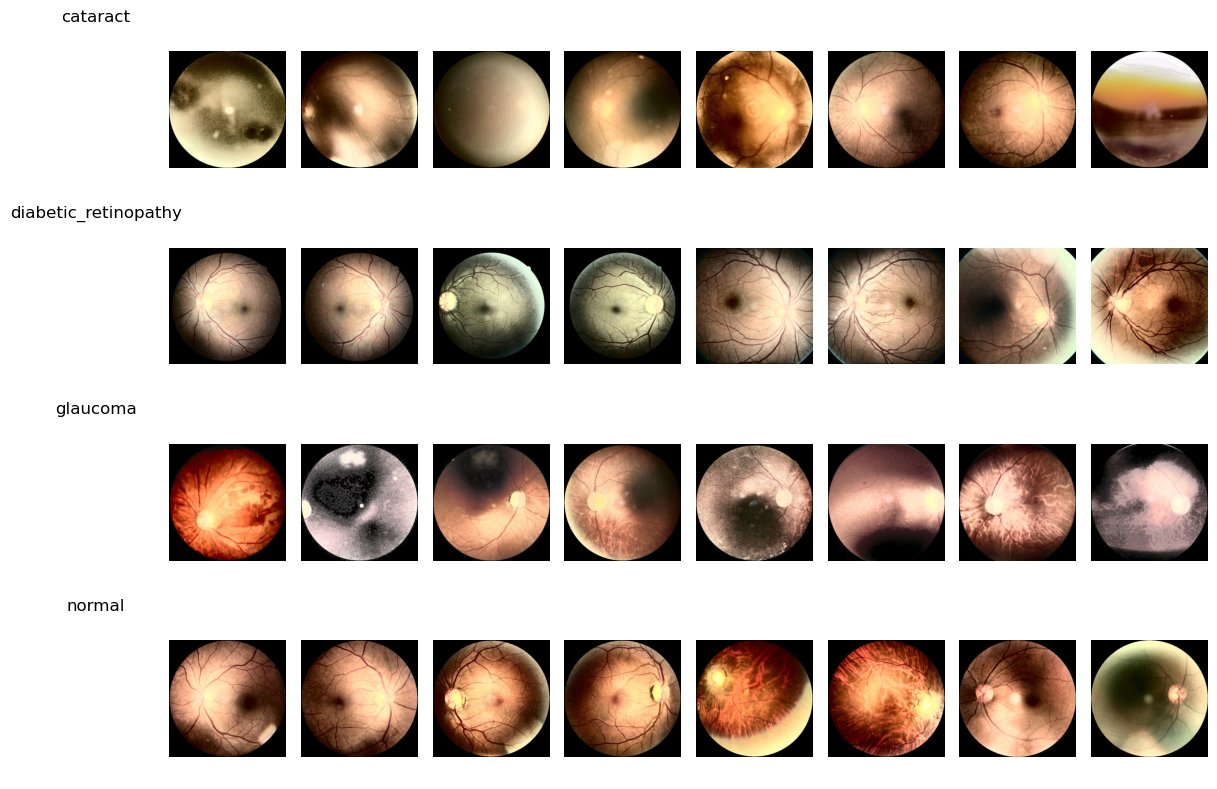

In [8]:
local_path = 'E:\Workplace\Projects\Eye disease detection\noise_reduced_dataset'
# Show 8 images from each class
num_images_to_display = 8  # Display 8 images for each class

num_rows = len(class_names)
num_cols = num_images_to_display + 1  # +1 for the title

plt.figure(figsize=(12, 8))

for i, class_name in enumerate(class_names):
    class_dir = data_dir / class_name
    image_files = list(class_dir.glob('*.*'))
    if image_files:
        plt.subplot(num_rows, num_cols, i * num_cols + 1)
        plt.title(class_name)
        plt.axis('off')
        for j in range(num_images_to_display):
            if j < len(image_files):
                sample_image = Image.open(image_files[j])
                plt.subplot(num_rows, num_cols, i * num_cols + j + 2)
                plt.imshow(sample_image)
                plt.axis('off')

plt.tight_layout()
plt.show()

### 4.3 Image sharpening

#### 4.3.1 Applying Image Sharping

In [56]:
# Define the source and destination paths using raw string literals
local_path = r'E:\Workplace\Projects\Eye disease detection\noise_reduced_dataset'
data_dir = pathlib.Path(local_path)
output_dir = r'E:\Workplace\Projects\Eye disease detection\sharpened_dataset'

# Ensure the output directory exists or create it
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Define a function to apply a sharpening effect to an image
def sharpen_image(image):
    # Define a sharpening kernel
    kernel = np.array([[-1, -1, -1],
                      [-1, 9, -1],
                      [-1, -1, -1]])
    
    # Apply the sharpening kernel to the image
    sharpened_img = cv2.filter2D(image, -1, kernel)
    
    return sharpened_img

# Loop through the equalized dataset and apply the sharpening effect
for class_dir in data_dir.iterdir():
    if class_dir.is_dir():
        output_class_dir = os.path.join(output_dir, class_dir.name)
        os.makedirs(output_class_dir, exist_ok=True)
        
        for image_path in class_dir.iterdir():
            if image_path.is_file():
                image = cv2.imread(str(image_path))
                
                if image is not None:
                    sharpened_img = sharpen_image(image)
                    output_path = os.path.join(output_class_dir, image_path.name)
                    cv2.imwrite(output_path, sharpened_img)

print("Sharpening effect applied to the equalized dataset and saved in the output directory.")

Sharpening effect applied to the equalized dataset and saved in the output directory.


#### 4.3.2 Data Sample Visualization of Each Class

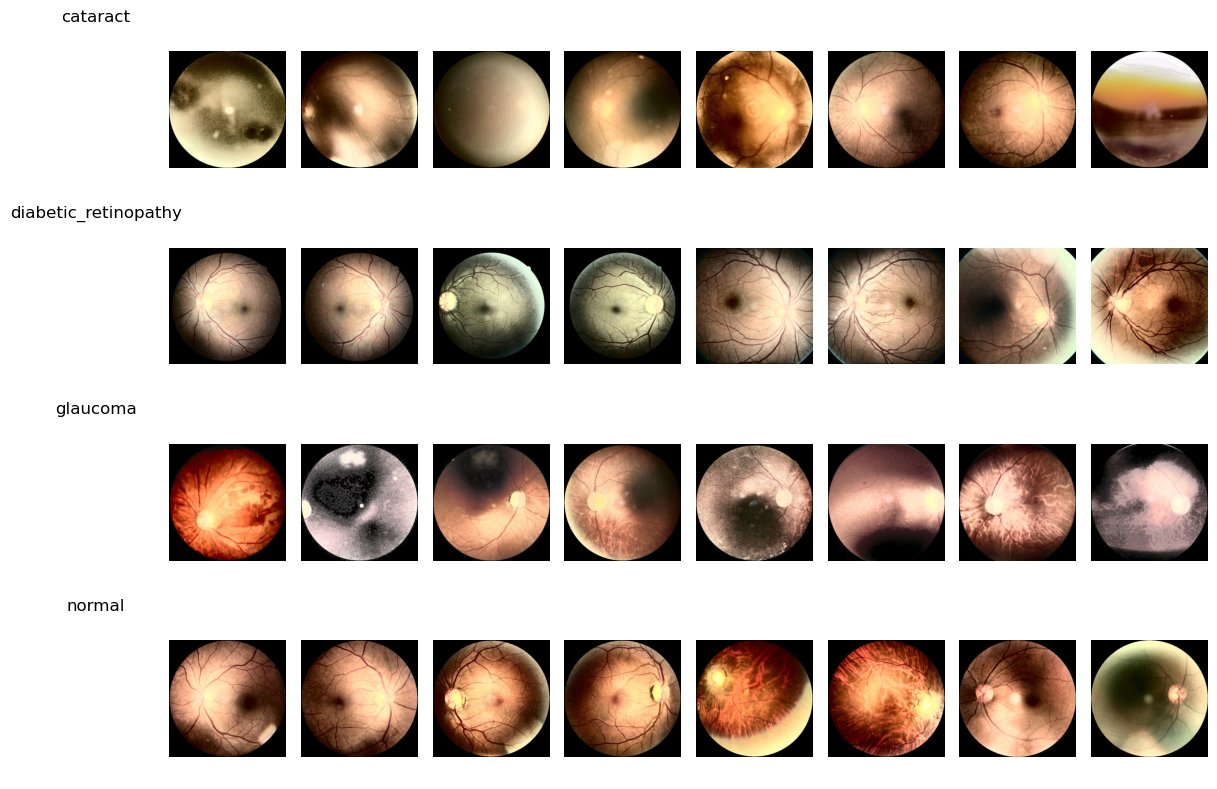

In [9]:
local_path = 'E:\Workplace\Projects\Eye disease detection\sharpened_dataset'
# Show 8 images from each class
num_images_to_display = 8  # Display 8 images for each class

num_rows = len(class_names)
num_cols = num_images_to_display + 1  # +1 for the title

plt.figure(figsize=(12, 8))

for i, class_name in enumerate(class_names):
    class_dir = data_dir / class_name
    image_files = list(class_dir.glob('*.*'))
    if image_files:
        plt.subplot(num_rows, num_cols, i * num_cols + 1)
        plt.title(class_name)
        plt.axis('off')
        for j in range(num_images_to_display):
            if j < len(image_files):
                sample_image = Image.open(image_files[j])
                plt.subplot(num_rows, num_cols, i * num_cols + j + 2)
                plt.imshow(sample_image)
                plt.axis('off')

plt.tight_layout()
plt.show()

### 4.4 Augmentation

#### 4.4.1 Augmenting data

In [62]:

# Define the source and destination paths
local_path = r'E:\Workplace\Projects\Eye disease detection\sharpened_dataset'
data_dir = pathlib.Path(local_path)
output_dir = r'E:\Workplace\Projects\Eye disease detection\final_augmented_dataset'


# Ensure the output directory exists or create it
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Define a function to apply data augmentation to an image
def augment_image(image, output_dir, image_name, num_augmentations=2):
    for i in range(num_augmentations):
        augmented_image = image.copy()
        
        # Randomly rotate the image by a degree between -10 and 10
        angle = random.randint(-10, 10)
        augmented_image = augmented_image.rotate(angle, resample=Image.BILINEAR, expand=True)
        
        # Randomly horizontally flip the image with a 50% probability
        if random.random() < 0.5:
            augmented_image = augmented_image.transpose(Image.FLIP_LEFT_RIGHT)
        
        # Save the augmented image
        augmented_image.save(os.path.join(output_dir, f"{image_name}_{i}.png"))

# Loop through the sharpened dataset and apply data augmentation to double the dataset
for class_dir in data_dir.iterdir():
    if class_dir.is_dir():
        output_class_dir = os.path.join(output_dir, class_dir.name)
        os.makedirs(output_class_dir, exist_ok=True)
        
        for image_path in class_dir.iterdir():
            if image_path.is_file():
                image = Image.open(image_path)
                image_name = os.path.splitext(image_path.name)[0]
                augment_image(image, output_class_dir, image_name)

print("Data augmentation applied to the sharpened dataset, and the dataset size has been doubled.")

Data augmentation applied to the sharpened dataset, and the dataset size has been doubled.


#### 4.4.2 Counting Total Image

In [10]:
local_path = r'E:\Workplace\Projects\Eye disease detection\final_augmented_dataset'
data_dir = pathlib.Path(local_path)

In [11]:

image_count = len(list(data_dir.glob('*/*.png')))
print(image_count)

8434


#### 4.4.3 Counting The The Number of Images In Each Class

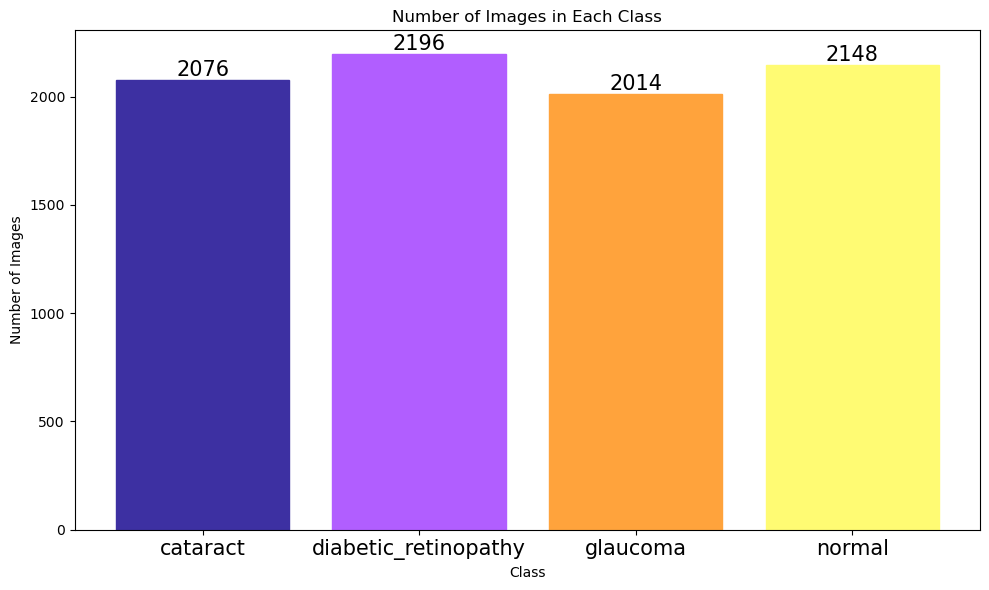

In [12]:
# Initialize a dictionary to store class names and image counts
class_counts = {}
# Iterate through subdirectories (classes) in data_dir
for class_dir in data_dir.iterdir():
    if class_dir.is_dir():
        class_name = class_dir.name
        # Count the number of image files in the class directory
        image_count = len([f for f in class_dir.iterdir() if f.is_file()])
        class_counts[class_name] = image_count
# Extract class names and counts for plotting
class_names = list(class_counts.keys())
image_counts = list(class_counts.values())
# Define a list of colors for the bars (you can customize the colors)
colors = [plt.cm.viridis(random.random()) for _ in class_names]
# Create a bar chart with custom colors
plt.figure(figsize=(10, 6))
bars = plt.bar(class_names, image_counts, color=colors)
plt.xlabel('Class')
plt.ylabel('Number of Images')
plt.title('Number of Images in Each Class')
plt.xticks(rotation=0, fontsize=15, ha="center")
# Customize the colors of the bars
# Define a list of custom colors for the bars
custom_colors = ['#3D30A2', '#B15EFF', '#FFA33C', '#FFFB73']
c=0
for bar, color in zip(bars, colors):
    bar.set_color(custom_colors[c])
    c=c+1

# Add count labels on top of the bars
for bar, count in zip(bars, image_counts):
    plt.text(bar.get_x() + bar.get_width() / 2, count, str(count),fontsize=15, ha='center', va='bottom')
plt.tight_layout()
# Show the bar chart
plt.show()

## 4. Assign Values To Parameter

In [13]:
classes = sorted(os.listdir(data_dir))
classes

['cataract', 'diabetic_retinopathy', 'glaucoma', 'normal']

In [14]:
image_size = (512, 512)
batch_size = 64
epoch = 15


## 5. Data Partitioning

### 5.1 Train & Test Partiotioning

In [15]:
# Define the directories for the training, validation, and test sets
train_dir = 'E:\Workplace\Projects\Eye disease detection\processed_splited_dataset\dtrain'
test_dir = 'E:\Workplace\Projects\Eye disease detection\processed_splited_dataset\dtest'

# Define the class labels (assuming you have four classes)
classes = ['cataract', 'diabetic_retinopathy', 'glaucoma', 'normal']
# Define the percentages for each split
train_split = 0.85
test_split = 0.15

# Iterate over the classes and create subdirectories for each split
for class_name in classes:
    class_directory = os.path.join(local_path, class_name)
    images = os.listdir(class_directory)
    random.shuffle(images)

    # Calculate the number of images for each split
    num_images = len(images)
    num_train = int(train_split * num_images)


    # Create subdirectories for each split
    os.makedirs(os.path.join(train_dir, class_name), exist_ok=True)

    os.makedirs(os.path.join(test_dir, class_name), exist_ok=True)

    # Copy images to the respective split directories
    for i, image in enumerate(images):
        source_path = os.path.join(class_directory, image)
        if i < num_train:
            destination_dir = train_dir
        else:
            destination_dir = test_dir
        destination_path = os.path.join(destination_dir, class_name, image)
        shutil.copy(source_path, destination_path)
print("Data partitioning was successfull!!!")

Data partitioning was successfull!!!


### 5.2 Count & Visualize Data After Partition

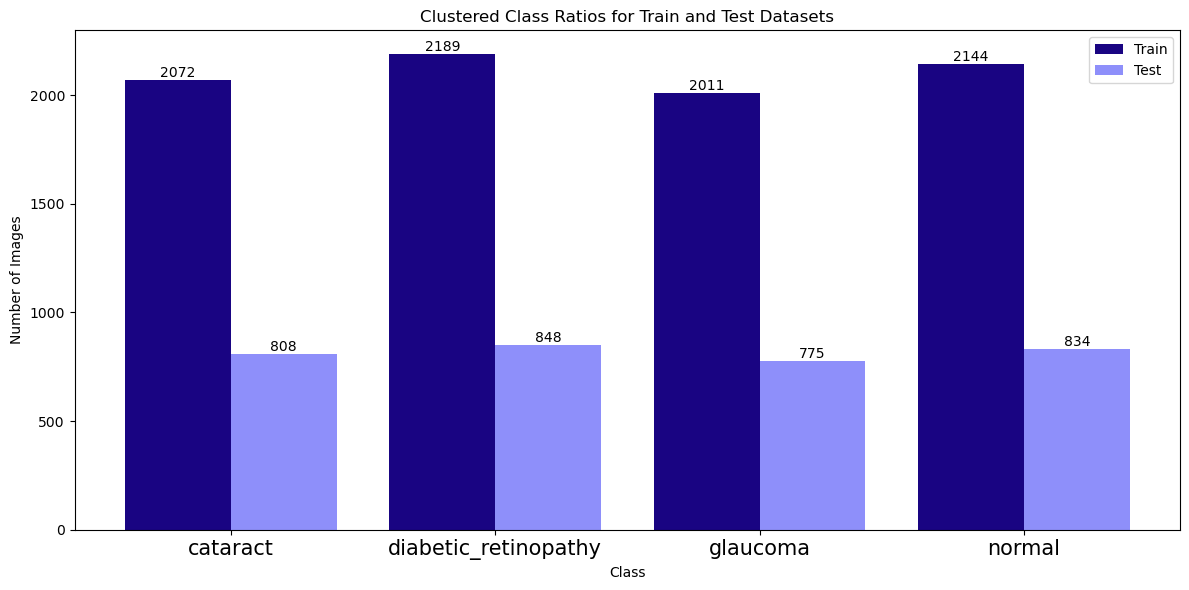

In [16]:
# Define the paths to your train and test datasets
train_dir = pathlib.Path('E:\Workplace\Projects\Eye disease detection\processed_splited_dataset\dtrain')
test_dir = pathlib.Path('E:\Workplace\Projects\Eye disease detection\processed_splited_dataset\dtest')

# Initialize dictionaries to store class counts for train and test
train_class_counts = {}
test_class_counts = {}

# Count the number of images for each class in the train dataset
for class_dir in train_dir.iterdir():
    if class_dir.is_dir():
        class_name = class_dir.name
        image_count = len(list(class_dir.glob('*.*')))
        train_class_counts[class_name] = image_count

# Count the number of images for each class in the test dataset
for class_dir in test_dir.iterdir():
    if class_dir.is_dir():
        class_name = class_dir.name
        image_count = len(list(class_dir.glob('*.*')))
        test_class_counts[class_name] = image_count

# Extract class names and counts for plotting
train_class_names = list(train_class_counts.keys())
train_image_counts = list(train_class_counts.values())

test_class_names = list(test_class_counts.keys())
test_image_counts = list(test_class_counts.values())

# Combine the train and test data for plotting
all_class_names = train_class_names
train_image_counts = np.array(train_image_counts)
test_image_counts = np.array(test_image_counts)

x = np.arange(len(all_class_names))
width = 0.40

plt.figure(figsize=(12, 6))
plt.bar(x - width/2, train_image_counts, width, label='Train', color='#190482')
plt.bar(x + width/2, test_image_counts, width, label='Test', color='#8E8FFA')
plt.title('Clustered Class Ratios for Train and Test Datasets')
plt.xlabel('Class')
plt.ylabel('Number of Images')
plt.legend()
plt.xticks(x, all_class_names, rotation=0, fontsize=15, ha="center")

# Add count labels on top of the bars
for i, count in enumerate(train_image_counts):
    plt.text(x[i] - width/2, count, str(count), ha='center', va='bottom', fontsize=10, color='black')
for i, count in enumerate(test_image_counts):
    plt.text(x[i] + width/2, count, str(count), ha='center', va='bottom', fontsize=10, color='black')

plt.tight_layout()
plt.show()

## 6. ResNet-50
ResNet stands for Residual Network and is a specific type of convolutional neural network that is 50 layers deep

### 6.1 Creating Subset

In [18]:
preprocess_input1 = tf.keras.applications.resnet50.preprocess_input

#### 6.1.1 Creating Training Subset

In [19]:
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input1,
    validation_split=0.2
)
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='training'
)

Found 6588 images belonging to 4 classes.


#### 6.1.2 Creating Test Subset

In [20]:
test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input1)
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

Found 2335 images belonging to 4 classes.


#### 6.1.3 Ceating Validation Subset

In [21]:
validation_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation'
)

Found 1645 images belonging to 4 classes.


### 6.2 Model

In [22]:
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(512, 512, 3))
for layer in base_model.layers:
    layer.trainable = False
x = base_model.output
x = GlobalAveragePooling2D()(x)
num_classes = len(class_names)
predictions = Dense(num_classes, activation='softmax')(x)

modelRN = Model(inputs=base_model.input, outputs=predictions)

modelRN.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
modelRN.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 512, 512, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 518, 518, 3)          0         ['input_1[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 256, 256, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 256, 256, 64)         256       ['conv1_conv[0][0]']          
 on)                                                                                          

                                                                                                  
 conv2_block3_1_conv (Conv2  (None, 128, 128, 64)         16448     ['conv2_block2_out[0][0]']    
 D)                                                                                               
                                                                                                  
 conv2_block3_1_bn (BatchNo  (None, 128, 128, 64)         256       ['conv2_block3_1_conv[0][0]'] 
 rmalization)                                                                                     
                                                                                                  
 conv2_block3_1_relu (Activ  (None, 128, 128, 64)         0         ['conv2_block3_1_bn[0][0]']   
 ation)                                                                                           
                                                                                                  
 conv2_blo

 ation)                                                                                           
                                                                                                  
 conv3_block2_3_conv (Conv2  (None, 64, 64, 512)          66048     ['conv3_block2_2_relu[0][0]'] 
 D)                                                                                               
                                                                                                  
 conv3_block2_3_bn (BatchNo  (None, 64, 64, 512)          2048      ['conv3_block2_3_conv[0][0]'] 
 rmalization)                                                                                     
                                                                                                  
 conv3_block2_add (Add)      (None, 64, 64, 512)          0         ['conv3_block1_out[0][0]',    
                                                                     'conv3_block2_3_bn[0][0]']   
          

 conv4_block1_2_conv (Conv2  (None, 32, 32, 256)          590080    ['conv4_block1_1_relu[0][0]'] 
 D)                                                                                               
                                                                                                  
 conv4_block1_2_bn (BatchNo  (None, 32, 32, 256)          1024      ['conv4_block1_2_conv[0][0]'] 
 rmalization)                                                                                     
                                                                                                  
 conv4_block1_2_relu (Activ  (None, 32, 32, 256)          0         ['conv4_block1_2_bn[0][0]']   
 ation)                                                                                           
                                                                                                  
 conv4_block1_0_conv (Conv2  (None, 32, 32, 1024)         525312    ['conv3_block4_out[0][0]']    
 D)       

                                                                                                  
 conv4_block3_out (Activati  (None, 32, 32, 1024)         0         ['conv4_block3_add[0][0]']    
 on)                                                                                              
                                                                                                  
 conv4_block4_1_conv (Conv2  (None, 32, 32, 256)          262400    ['conv4_block3_out[0][0]']    
 D)                                                                                               
                                                                                                  
 conv4_block4_1_bn (BatchNo  (None, 32, 32, 256)          1024      ['conv4_block4_1_conv[0][0]'] 
 rmalization)                                                                                     
                                                                                                  
 conv4_blo

 D)                                                                                               
                                                                                                  
 conv4_block6_3_bn (BatchNo  (None, 32, 32, 1024)         4096      ['conv4_block6_3_conv[0][0]'] 
 rmalization)                                                                                     
                                                                                                  
 conv4_block6_add (Add)      (None, 32, 32, 1024)         0         ['conv4_block5_out[0][0]',    
                                                                     'conv4_block6_3_bn[0][0]']   
                                                                                                  
 conv4_block6_out (Activati  (None, 32, 32, 1024)         0         ['conv4_block6_add[0][0]']    
 on)                                                                                              
          

 conv5_block3_1_relu (Activ  (None, 16, 16, 512)          0         ['conv5_block3_1_bn[0][0]']   
 ation)                                                                                           
                                                                                                  
 conv5_block3_2_conv (Conv2  (None, 16, 16, 512)          2359808   ['conv5_block3_1_relu[0][0]'] 
 D)                                                                                               
                                                                                                  
 conv5_block3_2_bn (BatchNo  (None, 16, 16, 512)          2048      ['conv5_block3_2_conv[0][0]'] 
 rmalization)                                                                                     
                                                                                                  
 conv5_block3_2_relu (Activ  (None, 16, 16, 512)          0         ['conv5_block3_2_bn[0][0]']   
 ation)   

### 6.3 Model Train & Validation

In [23]:
train_steps_per_epoch = train_generator.samples // batch_size
val_steps_per_epoch = validation_generator.samples // batch_size

In [24]:
class MetricsCallback(tf.keras.callbacks.Callback):
    def __init__(self):
        super(MetricsCallback, self).__init__()
        self.train_acc = []
        self.train_loss = []
        self.val_acc = []
        self.val_loss = []
        self.batch_nums = []

    def on_train_batch_end(self, batch, logs=None):
        self.train_acc.append(logs.get('accuracy'))
        self.train_loss.append(logs.get('loss'))
        self.batch_nums.append(batch)

    def on_test_batch_end(self, batch, logs=None):
        self.val_acc.append(logs.get('accuracy'))
        self.val_loss.append(logs.get('loss'))

metrics_callback = MetricsCallback()

In [25]:
historyRN = modelRN.fit(
    train_generator,
    steps_per_epoch=train_steps_per_epoch,
    epochs=epoch,
    validation_data=validation_generator,
    validation_steps=val_steps_per_epoch,
    callbacks=[metrics_callback]
)

Epoch 1/15
102/102 [==============================] - 1006s 10s/step - loss: 0.6529 - accuracy: 0.7293 - val_loss: 0.7951 - val_accuracy: 0.6719
Epoch 2/15
102/102 [==============================] - 997s 10s/step - loss: 0.4026 - accuracy: 0.8504 - val_loss: 0.8126 - val_accuracy: 0.6888
Epoch 3/15
102/102 [==============================] - 997s 10s/step - loss: 0.3396 - accuracy: 0.8758 - val_loss: 0.6540 - val_accuracy: 0.7406
Epoch 4/15
102/102 [==============================] - 998s 10s/step - loss: 0.3015 - accuracy: 0.8918 - val_loss: 0.8745 - val_accuracy: 0.6819
Epoch 5/15
102/102 [==============================] - 995s 10s/step - loss: 0.2794 - accuracy: 0.9008 - val_loss: 0.7666 - val_accuracy: 0.7025
Epoch 6/15
102/102 [==============================] - 994s 10s/step - loss: 0.2659 - accuracy: 0.9017 - val_loss: 0.9058 - val_accuracy: 0.6913
Epoch 7/15
102/102 [==============================] - 999s 10s/step - loss: 0.2446 - accuracy: 0.9113 - val_loss: 0.6654 - val_accuracy

### 6.4 Results

#### 6.4.1 Model Train Status

In [26]:
historyRN.history

{'loss': [0.6528645157814026,
  0.4026174545288086,
  0.3395563066005707,
  0.30147820711135864,
  0.279426246881485,
  0.2658691704273224,
  0.2446335405111313,
  0.23577822744846344,
  0.2223040759563446,
  0.21684187650680542,
  0.21120548248291016,
  0.19968435168266296,
  0.18448907136917114,
  0.1835835725069046,
  0.17689907550811768],
 'accuracy': [0.7293071746826172,
  0.8503985404968262,
  0.8758430480957031,
  0.8917841911315918,
  0.9008277058601379,
  0.9017474055290222,
  0.9112507700920105,
  0.9146229028701782,
  0.9190680384635925,
  0.918914794921875,
  0.9207541346549988,
  0.9296444058418274,
  0.933323085308075,
  0.9359288811683655,
  0.9408338665962219],
 'val_loss': [0.7950845956802368,
  0.8125598430633545,
  0.6539697051048279,
  0.8745442032814026,
  0.7666005492210388,
  0.9057684540748596,
  0.6654365658760071,
  0.7957035899162292,
  0.7354215979576111,
  0.7990984916687012,
  0.8157510161399841,
  0.8951194286346436,
  0.7322344183921814,
  0.761007845401

In [27]:
train_accuracy = historyRN.history['accuracy']
val_accuracy = historyRN.history['val_accuracy']
train_loss = historyRN.history['loss']
val_loss = historyRN.history['val_loss']
epochs = range(1, len(train_accuracy) + 1)
train_accuracy
epochs

range(1, 16)

#### 6.4.2 Traning And Validation Accuracy

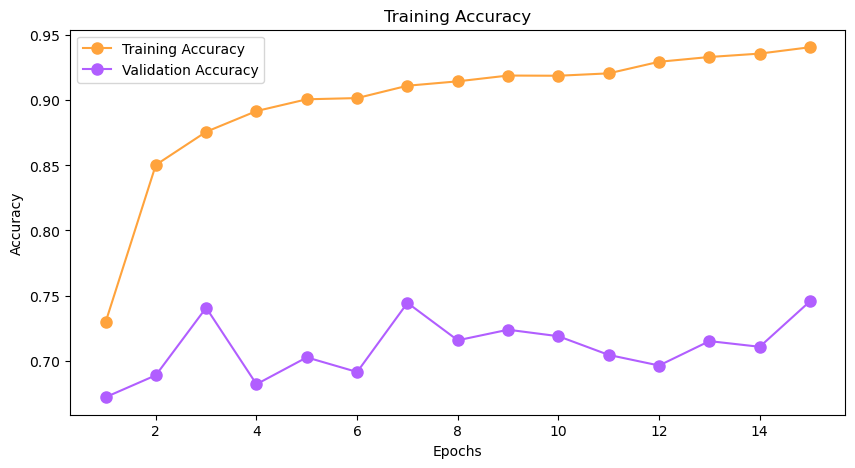

In [28]:
from matplotlib import pyplot as plt
import seaborn as sns
plt.figure(figsize=(10,5))
plt.plot(epochs, train_accuracy, '#FFA33C', marker='o', linestyle='-', markersize=8,label='Training Accuracy')
plt.plot(epochs, val_accuracy, '#B15EFF',marker='o', linestyle='-', markersize=8, label='Validation Accuracy')
plt.title('Training Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

#### 6.4.3 Traning And Validation Loss

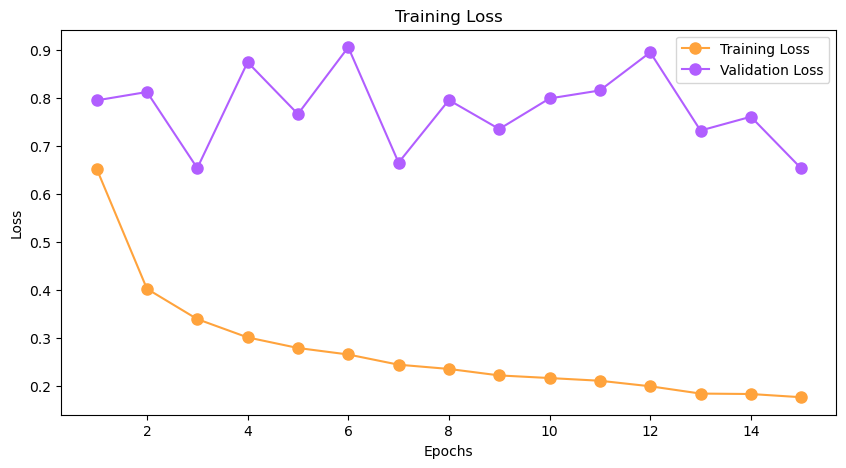

In [29]:
plt.figure(figsize=(10,5))
plt.plot(epochs, train_loss, '#FFA33C', marker='o', linestyle='-', markersize=8, label='Training Loss')
plt.plot(epochs, val_loss, '#B15EFF', marker='o', linestyle='-', markersize=8, label='Validation Loss')
plt.title('Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

#### 6.4.4 Data Prediction

In [30]:
predictions = modelRN.predict(test_generator)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = test_generator.classes

37/37 [==============================] - 297s 8s/step


In [31]:
predicted_classes

array([0, 0, 0, ..., 3, 3, 3], dtype=int64)

In [32]:
true_classes

array([0, 0, 0, ..., 3, 3, 3])

#### 6.4.5 Model Accuricy

In [33]:
from sklearn.metrics import classification_report, confusion_matrix, top_k_accuracy_score
class_labels = list(train_generator.class_indices.keys())
# class_labels = class_names
classification_report = classification_report(true_classes, predicted_classes, target_names=class_labels)
print(classification_report)

                      precision    recall  f1-score   support

            cataract       0.92      0.91      0.91       569
diabetic_retinopathy       0.99      0.97      0.98       606
            glaucoma       0.92      0.79      0.85       566
              normal       0.83      0.97      0.89       594

            accuracy                           0.91      2335
           macro avg       0.91      0.91      0.91      2335
        weighted avg       0.92      0.91      0.91      2335



#### 6.4.6 Confusion Matrix

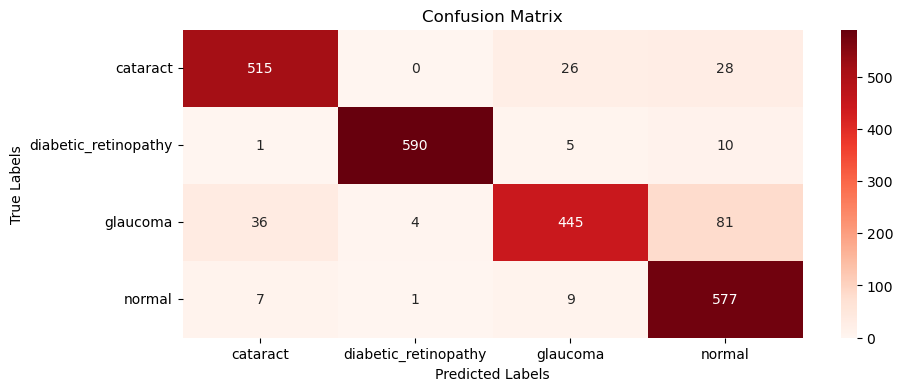

In [34]:
from matplotlib import pyplot as plt
import seaborn as sns
cm = confusion_matrix(true_classes, predicted_classes)

plt.figure(figsize=(10,4))
sns.heatmap(cm, annot=True, cmap='Reds', fmt='d', xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

#### 6.4.7 ROC Curve

ROC AUC score: 0.9885359952435322


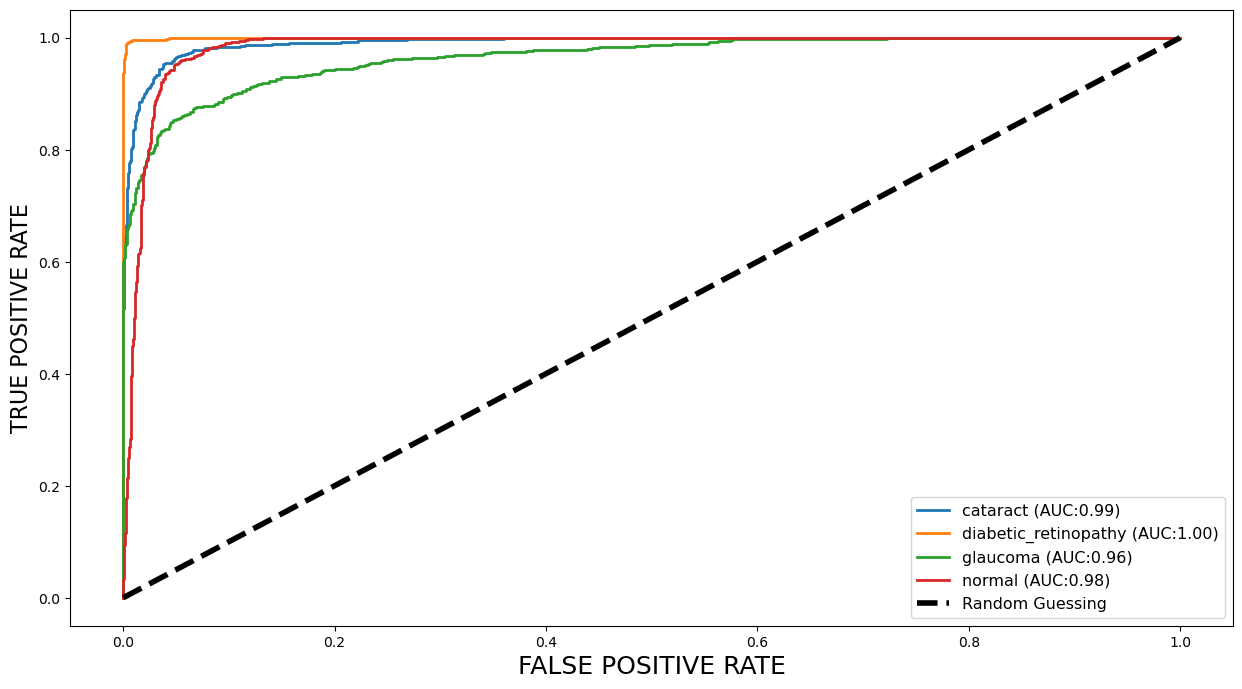

In [35]:
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import roc_curve, auc, roc_auc_score

# preds = model.predict(test_generator)
preds = predictions
# y_test = test_generator.classes
y_test = true_classes
fig, c_ax = plt.subplots(1,1, figsize = (15,8))

def multiclass_roc_auc_score(y_test, y_pred, average="macro"):
    lb = LabelBinarizer()
    lb.fit(y_test)
    y_test = lb.transform(y_test)
    for (idx, c_label) in enumerate(class_names):
        fpr, tpr, thresholds = roc_curve(y_test[:,idx].astype(int), y_pred[:,idx])
        c_ax.plot(fpr, tpr,lw=2, label = '%s (AUC:%0.2f)'  % (c_label, auc(fpr, tpr)))
    c_ax.plot(fpr, fpr, 'black',linestyle='dashed', lw=4, label = 'Random Guessing')
    return roc_auc_score(y_test, y_pred, average=average)

print('ROC AUC score:', multiclass_roc_auc_score(y_test , preds  , average = "micro"))
plt.xlabel('FALSE POSITIVE RATE', fontsize=18)
plt.ylabel('TRUE POSITIVE RATE', fontsize=16)
plt.legend(fontsize = 11.5)
plt.show()

#### 6.4.8 Saving the model

In [36]:
# Define a path where you want to save the model
model_path = "resnet50_modelp2.h5"

# Save the entire model
modelRN.save(model_path)

C:\Users\User\anaconda3\lib\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


## 7. DenseNet121
A DenseNet is a type of convolutional neural network that utilises dense connections between layers, through Dense Blocks, where we connect all layers (with matching feature-map sizes) directly with each other.

### 7.1 Creating Subset

In [17]:
preprocess_input2 = tf.keras.applications.densenet.preprocess_input


#### 7.1.1 Creating Training Subset

In [18]:
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input2,
    validation_split=0.2                                                                )
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size = image_size,
    batch_size = batch_size,
    shuffle  = True , 
    class_mode = "categorical",
    subset='training'
)

Found 6735 images belonging to 4 classes.


#### 7.1.2 Creating Test Subset

In [19]:
test_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input2
)
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=image_size,
    batch_size=batch_size,
    shuffle  = False , 
    class_mode = "categorical",
)

Found 3265 images belonging to 4 classes.


#### 7.1.3 Ceating Validation Subset

In [20]:
validation_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation'
)

Found 1681 images belonging to 4 classes.


### 7.2 Model

In [21]:
from keras.applications import DenseNet121
from keras.layers import GlobalAveragePooling2D, Dense
from keras.models import Model
from keras.optimizers import Adam
# Create a base model for DenseNet-121
base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(512, 512, 3))
# Freeze the layers in the base model
for layer in base_model.layers:
    layer.trainable = False
x = base_model.output
x = GlobalAveragePooling2D()(x)
num_classes = len(class_names)  # Replace with the number of classes in your dataset

# Add a dense layer for classification
predictions = Dense(num_classes, activation='softmax')(x)

# Create the final model
modelDN = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
modelDN.compile(optimizer=Adam(lr=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# Print model summary
modelDN.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 512, 512, 3)]        0         []                            
                                                                                                  
 zero_padding2d (ZeroPaddin  (None, 518, 518, 3)          0         ['input_1[0][0]']             
 g2D)                                                                                             
                                                                                                  
 conv1/conv (Conv2D)         (None, 256, 256, 64)         9408      ['zero_padding2d[0][0]']      
                                                                                                  
 conv1/bn (BatchNormalizati  (None, 256, 256, 64)         256       ['conv1/conv[0][0]']      

 conv2_block4_0_bn (BatchNo  (None, 128, 128, 160)        640       ['conv2_block3_concat[0][0]'] 
 rmalization)                                                                                     
                                                                                                  
 conv2_block4_0_relu (Activ  (None, 128, 128, 160)        0         ['conv2_block4_0_bn[0][0]']   
 ation)                                                                                           
                                                                                                  
 conv2_block4_1_conv (Conv2  (None, 128, 128, 128)        20480     ['conv2_block4_0_relu[0][0]'] 
 D)                                                                                               
                                                                                                  
 conv2_block4_1_bn (BatchNo  (None, 128, 128, 128)        512       ['conv2_block4_1_conv[0][0]'] 
 rmalizati

 rmalization)                                                                                     
                                                                                                  
 conv3_block1_1_relu (Activ  (None, 64, 64, 128)          0         ['conv3_block1_1_bn[0][0]']   
 ation)                                                                                           
                                                                                                  
 conv3_block1_2_conv (Conv2  (None, 64, 64, 32)           36864     ['conv3_block1_1_relu[0][0]'] 
 D)                                                                                               
                                                                                                  
 conv3_block1_concat (Conca  (None, 64, 64, 160)          0         ['pool2_pool[0][0]',          
 tenate)                                                             'conv3_block1_2_conv[0][0]'] 
          

 conv3_block5_1_bn (BatchNo  (None, 64, 64, 128)          512       ['conv3_block5_1_conv[0][0]'] 
 rmalization)                                                                                     
                                                                                                  
 conv3_block5_1_relu (Activ  (None, 64, 64, 128)          0         ['conv3_block5_1_bn[0][0]']   
 ation)                                                                                           
                                                                                                  
 conv3_block5_2_conv (Conv2  (None, 64, 64, 32)           36864     ['conv3_block5_1_relu[0][0]'] 
 D)                                                                                               
                                                                                                  
 conv3_block5_concat (Conca  (None, 64, 64, 288)          0         ['conv3_block4_concat[0][0]', 
 tenate)  

                                                                                                  
 conv3_block9_1_bn (BatchNo  (None, 64, 64, 128)          512       ['conv3_block9_1_conv[0][0]'] 
 rmalization)                                                                                     
                                                                                                  
 conv3_block9_1_relu (Activ  (None, 64, 64, 128)          0         ['conv3_block9_1_bn[0][0]']   
 ation)                                                                                           
                                                                                                  
 conv3_block9_2_conv (Conv2  (None, 64, 64, 32)           36864     ['conv3_block9_1_relu[0][0]'] 
 D)                                                                                               
                                                                                                  
 conv3_blo

 pool3_pool (AveragePooling  (None, 32, 32, 256)          0         ['pool3_conv[0][0]']          
 2D)                                                                                              
                                                                                                  
 conv4_block1_0_bn (BatchNo  (None, 32, 32, 256)          1024      ['pool3_pool[0][0]']          
 rmalization)                                                                                     
                                                                                                  
 conv4_block1_0_relu (Activ  (None, 32, 32, 256)          0         ['conv4_block1_0_bn[0][0]']   
 ation)                                                                                           
                                                                                                  
 conv4_block1_1_conv (Conv2  (None, 32, 32, 128)          32768     ['conv4_block1_0_relu[0][0]'] 
 D)       

                                                                                                  
 conv4_block4_concat (Conca  (None, 32, 32, 384)          0         ['conv4_block3_concat[0][0]', 
 tenate)                                                             'conv4_block4_2_conv[0][0]'] 
                                                                                                  
 conv4_block5_0_bn (BatchNo  (None, 32, 32, 384)          1536      ['conv4_block4_concat[0][0]'] 
 rmalization)                                                                                     
                                                                                                  
 conv4_block5_0_relu (Activ  (None, 32, 32, 384)          0         ['conv4_block5_0_bn[0][0]']   
 ation)                                                                                           
                                                                                                  
 conv4_blo

 D)                                                                                               
                                                                                                  
 conv4_block8_concat (Conca  (None, 32, 32, 512)          0         ['conv4_block7_concat[0][0]', 
 tenate)                                                             'conv4_block8_2_conv[0][0]'] 
                                                                                                  
 conv4_block9_0_bn (BatchNo  (None, 32, 32, 512)          2048      ['conv4_block8_concat[0][0]'] 
 rmalization)                                                                                     
                                                                                                  
 conv4_block9_0_relu (Activ  (None, 32, 32, 512)          0         ['conv4_block9_0_bn[0][0]']   
 ation)                                                                                           
          

 conv4_block12_2_conv (Conv  (None, 32, 32, 32)           36864     ['conv4_block12_1_relu[0][0]']
 2D)                                                                                              
                                                                                                  
 conv4_block12_concat (Conc  (None, 32, 32, 640)          0         ['conv4_block11_concat[0][0]',
 atenate)                                                            'conv4_block12_2_conv[0][0]']
                                                                                                  
 conv4_block13_0_bn (BatchN  (None, 32, 32, 640)          2560      ['conv4_block12_concat[0][0]']
 ormalization)                                                                                    
                                                                                                  
 conv4_block13_0_relu (Acti  (None, 32, 32, 640)          0         ['conv4_block13_0_bn[0][0]']  
 vation)  

                                                                                                  
 conv4_block16_2_conv (Conv  (None, 32, 32, 32)           36864     ['conv4_block16_1_relu[0][0]']
 2D)                                                                                              
                                                                                                  
 conv4_block16_concat (Conc  (None, 32, 32, 768)          0         ['conv4_block15_concat[0][0]',
 atenate)                                                            'conv4_block16_2_conv[0][0]']
                                                                                                  
 conv4_block17_0_bn (BatchN  (None, 32, 32, 768)          3072      ['conv4_block16_concat[0][0]']
 ormalization)                                                                                    
                                                                                                  
 conv4_blo

 vation)                                                                                          
                                                                                                  
 conv4_block20_2_conv (Conv  (None, 32, 32, 32)           36864     ['conv4_block20_1_relu[0][0]']
 2D)                                                                                              
                                                                                                  
 conv4_block20_concat (Conc  (None, 32, 32, 896)          0         ['conv4_block19_concat[0][0]',
 atenate)                                                            'conv4_block20_2_conv[0][0]']
                                                                                                  
 conv4_block21_0_bn (BatchN  (None, 32, 32, 896)          3584      ['conv4_block20_concat[0][0]']
 ormalization)                                                                                    
          

 conv4_block24_1_relu (Acti  (None, 32, 32, 128)          0         ['conv4_block24_1_bn[0][0]']  
 vation)                                                                                          
                                                                                                  
 conv4_block24_2_conv (Conv  (None, 32, 32, 32)           36864     ['conv4_block24_1_relu[0][0]']
 2D)                                                                                              
                                                                                                  
 conv4_block24_concat (Conc  (None, 32, 32, 1024)         0         ['conv4_block23_concat[0][0]',
 atenate)                                                            'conv4_block24_2_conv[0][0]']
                                                                                                  
 pool4_bn (BatchNormalizati  (None, 32, 32, 1024)         4096      ['conv4_block24_concat[0][0]']
 on)      

 rmalization)                                                                                     
                                                                                                  
 conv5_block4_0_relu (Activ  (None, 16, 16, 608)          0         ['conv5_block4_0_bn[0][0]']   
 ation)                                                                                           
                                                                                                  
 conv5_block4_1_conv (Conv2  (None, 16, 16, 128)          77824     ['conv5_block4_0_relu[0][0]'] 
 D)                                                                                               
                                                                                                  
 conv5_block4_1_bn (BatchNo  (None, 16, 16, 128)          512       ['conv5_block4_1_conv[0][0]'] 
 rmalization)                                                                                     
          

 conv5_block8_0_bn (BatchNo  (None, 16, 16, 736)          2944      ['conv5_block7_concat[0][0]'] 
 rmalization)                                                                                     
                                                                                                  
 conv5_block8_0_relu (Activ  (None, 16, 16, 736)          0         ['conv5_block8_0_bn[0][0]']   
 ation)                                                                                           
                                                                                                  
 conv5_block8_1_conv (Conv2  (None, 16, 16, 128)          94208     ['conv5_block8_0_relu[0][0]'] 
 D)                                                                                               
                                                                                                  
 conv5_block8_1_bn (BatchNo  (None, 16, 16, 128)          512       ['conv5_block8_1_conv[0][0]'] 
 rmalizati

                                                                                                  
 conv5_block12_0_bn (BatchN  (None, 16, 16, 864)          3456      ['conv5_block11_concat[0][0]']
 ormalization)                                                                                    
                                                                                                  
 conv5_block12_0_relu (Acti  (None, 16, 16, 864)          0         ['conv5_block12_0_bn[0][0]']  
 vation)                                                                                          
                                                                                                  
 conv5_block12_1_conv (Conv  (None, 16, 16, 128)          110592    ['conv5_block12_0_relu[0][0]']
 2D)                                                                                              
                                                                                                  
 conv5_blo

 atenate)                                                            'conv5_block15_2_conv[0][0]']
                                                                                                  
 conv5_block16_0_bn (BatchN  (None, 16, 16, 992)          3968      ['conv5_block15_concat[0][0]']
 ormalization)                                                                                    
                                                                                                  
 conv5_block16_0_relu (Acti  (None, 16, 16, 992)          0         ['conv5_block16_0_bn[0][0]']  
 vation)                                                                                          
                                                                                                  
 conv5_block16_1_conv (Conv  (None, 16, 16, 128)          126976    ['conv5_block16_0_relu[0][0]']
 2D)                                                                                              
          

### 7.3 Model Train & Validation

In [22]:
train_steps_per_epoch = train_generator.samples // batch_size
val_steps_per_epoch = validation_generator.samples // batch_size

In [23]:
class MetricsCallback(tf.keras.callbacks.Callback):
    def __init__(self):
        super(MetricsCallback, self).__init__()
        self.train_acc = []
        self.train_loss = []
        self.val_acc = []
        self.val_loss = []
        self.batch_nums = []

    def on_train_batch_end(self, batch, logs=None):
        self.train_acc.append(logs.get('accuracy'))
        self.train_loss.append(logs.get('loss'))
        self.batch_nums.append(batch)

    def on_test_batch_end(self, batch, logs=None):
        self.val_acc.append(logs.get('accuracy'))
        self.val_loss.append(logs.get('loss'))

metrics_callback = MetricsCallback()

In [24]:
historyDN = modelDN.fit(
    train_generator,
    steps_per_epoch=train_steps_per_epoch,
    epochs=epoch,
    validation_data=validation_generator,
    validation_steps=val_steps_per_epoch,
    callbacks=[metrics_callback]
)

Epoch 1/15
105/105 [==============================] - 1002s 10s/step - loss: 0.8106 - accuracy: 0.6845 - val_loss: 0.9226 - val_accuracy: 0.6124
Epoch 2/15
105/105 [==============================] - 1001s 10s/step - loss: 0.5129 - accuracy: 0.8123 - val_loss: 0.8907 - val_accuracy: 0.6292
Epoch 3/15
105/105 [==============================] - 1006s 10s/step - loss: 0.4521 - accuracy: 0.8327 - val_loss: 0.8259 - val_accuracy: 0.6647
Epoch 4/15
105/105 [==============================] - 1006s 10s/step - loss: 0.4155 - accuracy: 0.8507 - val_loss: 0.8409 - val_accuracy: 0.6635
Epoch 5/15
105/105 [==============================] - 1008s 10s/step - loss: 0.3895 - accuracy: 0.8592 - val_loss: 0.8154 - val_accuracy: 0.6623
Epoch 6/15
105/105 [==============================] - 1009s 10s/step - loss: 0.3687 - accuracy: 0.8676 - val_loss: 0.8106 - val_accuracy: 0.6719
Epoch 7/15
105/105 [==============================] - 1011s 10s/step - loss: 0.3564 - accuracy: 0.8711 - val_loss: 0.7809 - val_ac

### 7.4 Results

#### 7.4.1 Model Train Status

In [25]:
historyDN.history

{'loss': [0.8106241226196289,
  0.5128698945045471,
  0.4520951509475708,
  0.41551661491394043,
  0.38945746421813965,
  0.36871686577796936,
  0.3563644587993622,
  0.3428792655467987,
  0.33120542764663696,
  0.32005107402801514,
  0.31417226791381836,
  0.3108099400997162,
  0.29736781120300293,
  0.2932431399822235,
  0.2868656814098358],
 'accuracy': [0.6844550967216492,
  0.8123219609260559,
  0.8327087163925171,
  0.8506970405578613,
  0.8592414855957031,
  0.8676360249519348,
  0.8710837960243225,
  0.8779793381690979,
  0.8811272382736206,
  0.8865237832069397,
  0.8842751979827881,
  0.8862239718437195,
  0.8925198912620544,
  0.8941687941551208,
  0.9000149965286255],
 'val_loss': [0.9226113557815552,
  0.8906732201576233,
  0.8259304761886597,
  0.8409367203712463,
  0.8154361248016357,
  0.8105736970901489,
  0.7809310555458069,
  0.7357558608055115,
  0.8111108541488647,
  0.7446473836898804,
  0.7095086574554443,
  0.6818695664405823,
  0.8921853303909302,
  0.884632408

In [26]:
train_accuracy = historyDN.history['accuracy']
val_accuracy = historyDN.history['val_accuracy']
train_loss = historyDN.history['loss']
val_loss = historyDN.history['val_loss']
epochs = range(1, len(train_accuracy) + 1)
train_accuracy
epochs

range(1, 16)

#### 7.4.2 Traning And Validation Accuracy

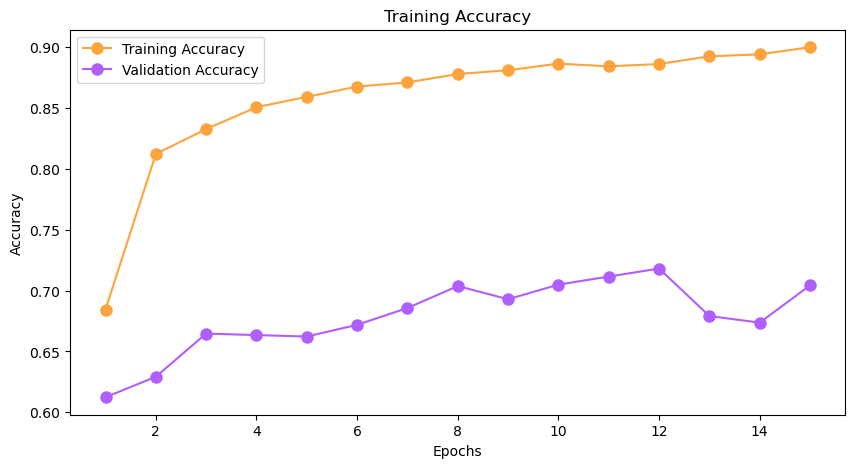

In [27]:
from matplotlib import pyplot as plt
import seaborn as sns
plt.figure(figsize=(10,5))
plt.plot(epochs, train_accuracy, '#FFA33C', marker='o', linestyle='-', markersize=8,label='Training Accuracy')
plt.plot(epochs, val_accuracy, '#B15EFF',marker='o', linestyle='-', markersize=8, label='Validation Accuracy')
plt.title('Training Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

#### 7.4.3 Traning And Validation Loss

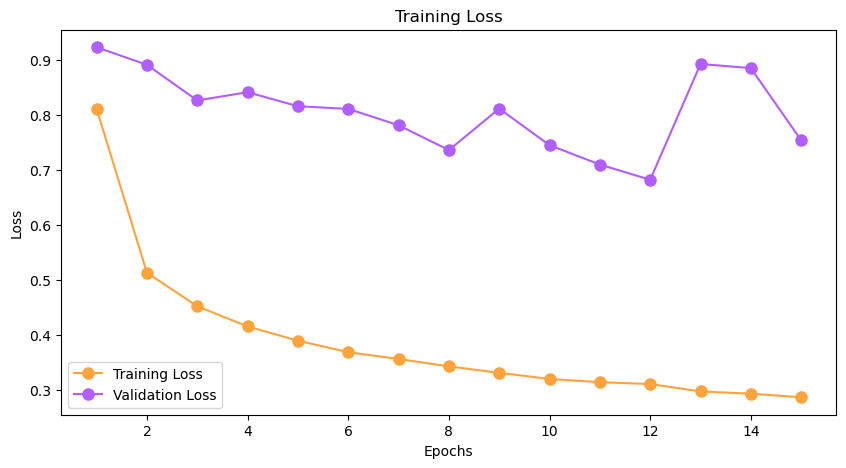

In [28]:
plt.figure(figsize=(10,5))
plt.plot(epochs, train_loss, '#FFA33C', marker='o', linestyle='-', markersize=8, label='Training Loss')
plt.plot(epochs, val_loss, '#B15EFF', marker='o', linestyle='-', markersize=8, label='Validation Loss')
plt.title('Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

#### 7.4.4 Data Prediction

In [29]:
predictions = modelDN.predict(test_generator)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = test_generator.classes

52/52 [==============================] - 400s 8s/step


In [30]:
predicted_classes

array([0, 0, 0, ..., 3, 3, 3], dtype=int64)

In [31]:
true_classes

array([0, 0, 0, ..., 3, 3, 3])

#### 7.4.5 Model Accuricy

In [32]:
from sklearn.metrics import classification_report, confusion_matrix, top_k_accuracy_score
class_labels = list(train_generator.class_indices.keys())
# class_labels = class_names
classification_report = classification_report(true_classes, predicted_classes, target_names=class_labels)
print(classification_report)

                      precision    recall  f1-score   support

            cataract       0.90      0.83      0.87       808
diabetic_retinopathy       0.96      0.97      0.97       848
            glaucoma       0.85      0.67      0.75       775
              normal       0.77      0.96      0.85       834

            accuracy                           0.86      3265
           macro avg       0.87      0.86      0.86      3265
        weighted avg       0.87      0.86      0.86      3265



#### 7.4.6 Confusion Matrix

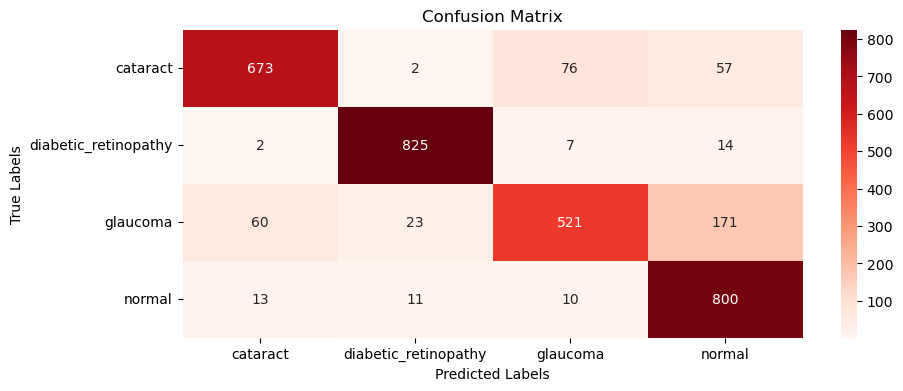

In [33]:
from matplotlib import pyplot as plt
import seaborn as sns
cm = confusion_matrix(true_classes, predicted_classes)

plt.figure(figsize=(10,4))
sns.heatmap(cm, annot=True, cmap='Reds', fmt='d', xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

#### 7.4.7 ROC Curve

ROC AUC score: 0.9750590317433888


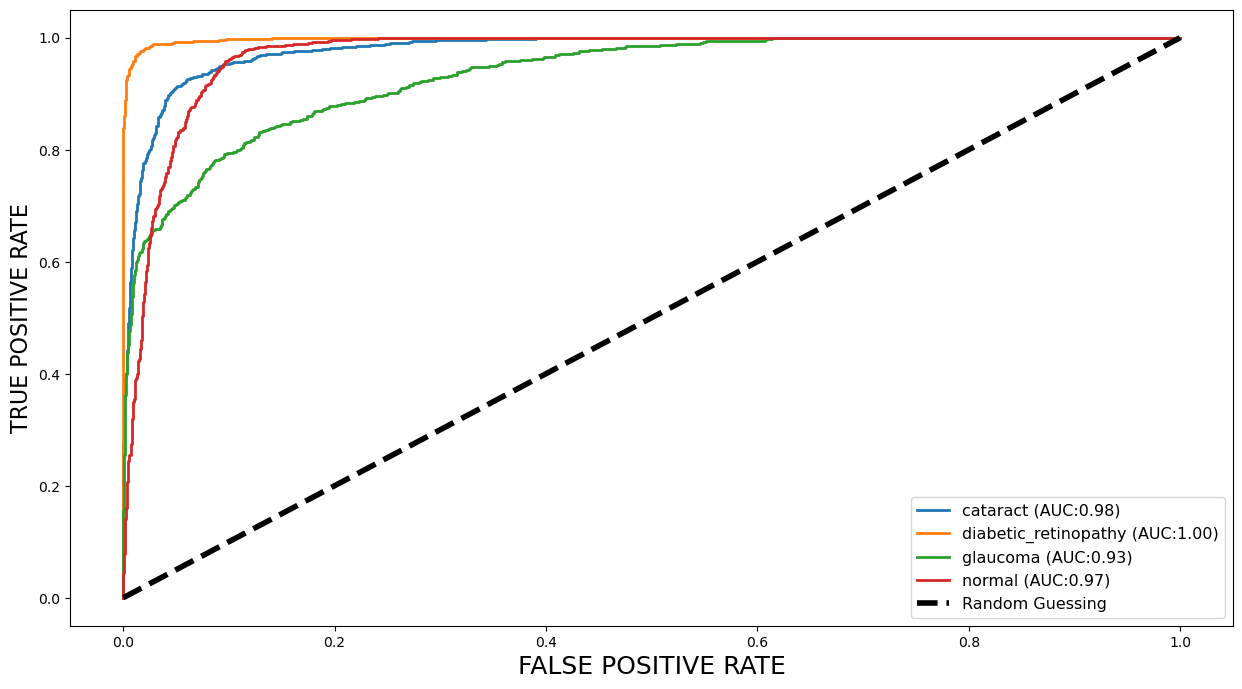

In [34]:
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import roc_curve, auc, roc_auc_score

# preds = model.predict(test_generator)
preds = predictions
# y_test = test_generator.classes
y_test = true_classes
fig, c_ax = plt.subplots(1,1, figsize = (15,8))

def multiclass_roc_auc_score(y_test, y_pred, average="macro"):
    lb = LabelBinarizer()
    lb.fit(y_test)
    y_test = lb.transform(y_test)
    for (idx, c_label) in enumerate(class_names):
        fpr, tpr, thresholds = roc_curve(y_test[:,idx].astype(int), y_pred[:,idx])
        c_ax.plot(fpr, tpr,lw=2, label = '%s (AUC:%0.2f)'  % (c_label, auc(fpr, tpr)))
    c_ax.plot(fpr, fpr, 'black',linestyle='dashed', lw=4, label = 'Random Guessing')
    return roc_auc_score(y_test, y_pred, average=average)

print('ROC AUC score:', multiclass_roc_auc_score(y_test , preds  , average = "micro"))
plt.xlabel('FALSE POSITIVE RATE', fontsize=18)
plt.ylabel('TRUE POSITIVE RATE', fontsize=16)
plt.legend(fontsize = 11.5)
plt.show()

#### 7.4.8 Saving the model

In [36]:
# Define a path where you want to save the model
model_path = "densenet121_modelp2.h5"

# Save the entire model
modelDN.save(model_path)

C:\Users\User\anaconda3\lib\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
